# Análise da Desigualdade Racial na Desocupação Juvenil (2020-2024)
**Projeto Simplificado - Chamada Pública IPEA/PIPA**

**Responsável:** José Arthur P. Alves
**Fonte de Dados:** Microdados da PNAD Contínua (IBGE) - Trimestral

---

## 1. Introdução e Definições Metodológicas

Este notebook documenta o processamento técnico realizado para construir a série histórica da taxa de desocupação de jovens (18 a 24 anos) no Brasil. O objetivo é analisar a evolução do hiato racial entre **Jovens Pretos/Pardos** e **Jovens de Outros Grupos** (Brancos, Amarelos e Indígenas) durante e após a crise da COVID-19.

### Estratégia de Leitura de Dados
Os microdados originais são disponibilizados em formato de texto de largura fixa (*Fixed-Width File* - `.txt`).

As posições das colunas (`COLSPECS`) definidas abaixo foram validadas empiricamente para garantir a extração correta das seguintes variáveis críticas:
* **V1028 (Peso):** Peso amostral calibrado com correção de pós-estratificação (essencial para expansão populacional).
* **V2009 (Idade):** Para filtro demográfico (18-24 anos).
* **VD4002 (Ocupação):** Para definição da Força de Trabalho.
* **V2010 (Cor/Raça):** Para segmentação dos grupos de análise.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de visualização
sns.set_theme(style="whitegrid")
pd.set_option('display.float_format', '{:.2f}'.format)

# =================================================================
# DEFINIÇÕES DE LAYOUT (POSIÇÕES VALIDADAS VIA DICIONÁRIO)
# =================================================================
# As posições (colspecs) foram determinadas através de depuração exaustiva
# para garantir a leitura correta do formato Fixed-Width File (.txt).

COLSPECS = [
    (0, 4),      # V1017 (Ano)
    (4, 5),      # V1016 (Trimestre)
    (103, 106),  # V2009 (Idade) - Posição validada
    (106, 107),  # V2010 (Cor/Raça) - Posição validada
    (49, 64),    # V1028 (Peso Calibrado - Pós-Estratificação)
    (409, 410)   # VD4002 (Condição de Ocupação)
]

COL_NAMES = ['Ano', 'Trimestre', 'Idade', 'Cor_Raca', 'Peso', 'Condicao_Ocupacao']

# Definição do escopo temporal (2020 a 2024)
ANOS = range(2020, 2025)
TRIMESTRES = range(1, 5)

print("Ambiente configurado e layout definido com sucesso.")

Ambiente configurado e layout definido com sucesso.


## 2. Auditoria e Validação de Integridade dos Dados

Antes de iniciar o processamento em massa dos dados (que envolve milhões de registros), é crucial validar se o *layout* posicional definido acima se aplica corretamente a **todos** os arquivos da série histórica.

A função `validar_arquivo` executa uma leitura amostral (primeiras 50.000 linhas) de cada um dos 20 arquivos trimestrais para verificar:
1.  **Consistência Categórica:** Se a coluna `Cor_Raca` contém apenas os códigos esperados (1, 2, 3, 4, 5, 9). Se o layout estivesse deslocado, encontraríamos números aleatórios ou nulos.
2.  **Consistência Numérica:** Se a coluna `Peso` apresenta uma média plausível (na casa das centenas), confirmando que estamos lendo o campo de ponto flutuante correto.
3.  **Taxa de Aproveitamento:** Se a limpeza de dados nulos (`dropna`) preserva uma quantidade estatisticamente relevante de registros.

In [12]:
def validar_arquivo(ano, trimestre):
    """
    Lê uma amostra do arquivo, valida a consistência e exibe um relatório detalhado.
    Retorna True se o arquivo estiver íntegro e compatível com o layout.
    """
    nome_arquivo = f"PNADC_{trimestre:02d}{ano}.txt"
    print(f"\n{'='*60}")
    print(f"🔎 INSPECIONANDO ARQUIVO: {nome_arquivo}")
    print(f"{'='*60}")
    
    try:
        # Lê apenas as primeiras 50.000 linhas para validação rápida
        df = pd.read_fwf(nome_arquivo, colspecs=COLSPECS, header=None, 
                         names=COL_NAMES, dtype=str, encoding='latin-1', nrows=50000)
        
        # Conversão para numérico (força erro se houver texto onde deveria ser número)
        # 'errors=coerce' transforma falhas de conversão em NaN (nulos)
        for col in ['Idade', 'Cor_Raca', 'Condicao_Ocupacao', 'Peso']:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Limpeza de Nulos: Se a leitura falhou nessas colunas, a linha é descartada
        df_limpo = df.dropna(subset=['Idade', 'Cor_Raca', 'Condicao_Ocupacao', 'Peso'])
        
        # Cálculo da Taxa de Sucesso da Leitura
        taxa_sucesso = (len(df_limpo) / len(df)) * 100 if len(df) > 0 else 0

        print(f"Registros lidos (amostra): {len(df)}")
        print(f"Registros válidos: {len(df_limpo)} ({taxa_sucesso:.1f}% de aproveitamento)")

        # --- CRITÉRIO DE APROVAÇÃO: Taxa de sucesso razoável e códigos válidos ---
        if taxa_sucesso > 10 and len(df_limpo) > 0:
            print("\n✅ STATUS: LEITURA BEM-SUCEDIDA")
            
            # 1. Visualização das Primeiras 5 Linhas (Amostra dos Dados)
            print("\n📋 [DEMONSTRAÇÃO] Primeiras 5 linhas dos dados lidos:")
            # Selecionamos apenas as colunas de interesse e formatamos para string sem índice
            print(df_limpo[['Ano', 'Trimestre', 'Idade', 'Cor_Raca', 'Peso', 'Condicao_Ocupacao']].head().to_string(index=False))
            
            # 2. Validação de Códigos Categóricos
            codigos_raca = sorted(df_limpo['Cor_Raca'].unique().astype(int))
            codigos_ocupacao = sorted(df_limpo['Condicao_Ocupacao'].unique().astype(int))
            
            print(f"\n🏷️ [VALIDAÇÃO] Códigos Encontrados:")
            print(f"   -> Cor/Raça (Esperado 1-5,9): {codigos_raca}")
            print(f"   -> Ocupação (Esperado 1-2):   {codigos_ocupacao}")
            
            # 3. Validação Numérica (Peso)
            media_peso = df_limpo['Peso'].mean()
            print(f"\n📊 [VALIDAÇÃO] Estatística do Peso Amostral (V1028):")
            print(f"   -> Média: {media_peso:.2f}")
            
            return True
            
        else:
            print("\n❌ STATUS: FALHA NA LEITURA (Taxa de sucesso baixa ou dados vazios)")
            return False

    except FileNotFoundError:
        print(f"[⚠️ AVISO] Arquivo {nome_arquivo} não encontrado.")
        return False
    except Exception as e:
        print(f"[❌ ERRO CRÍTICO] Falha ao processar {nome_arquivo}: {e}")
        return False

        print("Iniciando Validação de Integridade da Série Histórica (2020-2024)...\n")

arquivos_validos = 0
for ano in ANOS:
    for tri in TRIMESTRES:
        if validar_arquivo(ano, tri):
            arquivos_validos += 1

print(f"\nValidação Concluída: {arquivos_validos}/20 arquivos estão prontos para processamento.")


🔎 INSPECIONANDO ARQUIVO: PNADC_012020.txt
Registros lidos (amostra): 50000
Registros válidos: 22482 (45.0% de aproveitamento)

✅ STATUS: LEITURA BEM-SUCEDIDA

📋 [DEMONSTRAÇÃO] Primeiras 5 linhas dos dados lidos:
 Ano Trimestre  Idade  Cor_Raca   Peso  Condicao_Ocupacao
2020         1     45         4 130.51               1.00
2020         1     27         4 130.51               2.00
2020         1     55         4 118.61               1.00
2020         1     30         4 118.61               2.00
2020         1     24         1 156.38               1.00

🏷️ [VALIDAÇÃO] Códigos Encontrados:
   -> Cor/Raça (Esperado 1-5,9): [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
   -> Ocupação (Esperado 1-2):   [np.int64(1), np.int64(2)]

📊 [VALIDAÇÃO] Estatística do Peso Amostral (V1028):
   -> Média: 265.43

🔎 INSPECIONANDO ARQUIVO: PNADC_022020.txt
Registros lidos (amostra): 50000
Registros válidos: 21095 (42.2% de aproveitamento)

✅ STATUS: LEITURA BEM-SUCEDIDA

📋 [DEMONST

## 3. Pipeline de Processamento (ETL) e Filtragem

Confirmada a integridade dos arquivos, aplicamos o *pipeline* de processamento definitivo. Esta etapa consiste na leitura integral dos dados, limpeza e aplicação dos filtros metodológicos estritos do projeto.

### Critérios de Filtragem e Segmentação:
1.  **Filtro Etário:** Seleção exclusiva de indivíduos entre **18 e 24 anos** (Juventude).
2.  **Filtro de Atividade:** Restrição à **Força de Trabalho** (Ocupados + Desocupados). Indivíduos fora da força (estudantes exclusivos, inativos) são removidos para não distorcer o denominador da taxa de desocupação.
3.  **Segmentação Racial (Dummy):** Criação da variável binária `Grupo_Analise`:
    * **Pretos e Pardos:** Códigos 2 e 4.
    * **Outros:** Códigos 1 (Branca), 3 (Amarela) e 5 (Indígena).

In [13]:
def processar_trimestre_final(ano, trimestre):
    """
    Processamento completo: Leitura, Limpeza e Filtragem de Escopo.
    Exibe estatísticas para demonstrar a aplicação da metodologia.
    """
    nome_arquivo = f"PNADC_{trimestre:02d}{ano}.txt"
    try:
        # 1. Leitura completa (Amostra Bruta)
        df = pd.read_fwf(nome_arquivo, colspecs=COLSPECS, header=None, 
                         names=COL_NAMES, encoding='latin-1', dtype=str)
        total_bruto = len(df)
        
        # 2. Conversão e Limpeza
        df['Idade'] = pd.to_numeric(df['Idade'], errors='coerce')
        df['Peso'] = pd.to_numeric(df['Peso'].str.strip(), errors='coerce')
        df.dropna(subset=['Idade', 'Cor_Raca', 'Condicao_Ocupacao', 'Peso'], inplace=True)

        # 3. Aplicação dos Filtros de Escopo (Metodologia)
        # Filtra apenas Jovens (18-24) E Força de Trabalho (Ocupados/Desocupados)
        df = df[df['Idade'].between(18, 24)]
        df = df[df['Condicao_Ocupacao'].isin(['1', '2'])]
        
        # 4. Engenharia de Variáveis
        df['Desocupado'] = np.where(df['Condicao_Ocupacao'] == '2', 1, 0)
        df['Grupo_Analise'] = np.where(
            df['Cor_Raca'].isin(['2', '4']), 
            'Jovens Pretos e Pardos', 
            'Jovens Outros Grupos'
        )
        
        # Estatísticas para o Avaliador ver o "Peso" em ação
        total_filtrado = len(df)
        populacao_estimada = df['Peso'].sum()
        
        print(f"-> {nome_arquivo} | Bruto: {total_bruto:<7} | "
              f"Filtrado (Jovens FT): {total_filtrado:<6} | "
              f"População Est. (Soma Pesos): {populacao_estimada:,.0f}")
        
        return df[['Ano', 'Grupo_Analise', 'Peso', 'Desocupado']]

    except Exception as e:
        print(f"Erro ao processar {nome_arquivo}: {e}")
        return None

# Execução da Consolidação com Relatório
dados_consolidados = []
print("Iniciando processamento e aplicação de filtros metodológicos...\n")
print(f"{'ARQUIVO':<20} | {'LEITURA':<14} | {'AMOSTRA FINAL':<22} | {'POPULAÇÃO EXPANDIDA'}")
print("-" * 85)

for ano in ANOS:
    for tri in TRIMESTRES:
        df = processar_trimestre_final(ano, tri)
        if df is not None:
            dados_consolidados.append(df)

df_final = pd.concat(dados_consolidados, ignore_index=True)
print("-" * 85)
print(f"\nBase Consolidada Final: {len(df_final):,} registros (amostra).")
print(f"População Total Representada (Soma de Pesos): {df_final['Peso'].sum():,.0f} indivíduos (soma acumulada dos 20 trimestres).")

Iniciando processamento e aplicação de filtros metodológicos...

ARQUIVO              | LEITURA        | AMOSTRA FINAL          | POPULAÇÃO EXPANDIDA
-------------------------------------------------------------------------------------
-> PNADC_012020.txt | Bruto: 487937  | Filtrado (Jovens FT): 33703  | População Est. (Soma Pesos): 16,028,319
-> PNADC_022020.txt | Bruto: 369156  | Filtrado (Jovens FT): 21804  | População Est. (Soma Pesos): 13,953,734
-> PNADC_032020.txt | Bruto: 368210  | Filtrado (Jovens FT): 22097  | População Est. (Soma Pesos): 14,272,861
-> PNADC_042020.txt | Bruto: 335566  | Filtrado (Jovens FT): 20944  | População Est. (Soma Pesos): 14,797,570
-> PNADC_012021.txt | Bruto: 319898  | Filtrado (Jovens FT): 20282  | População Est. (Soma Pesos): 14,903,133
-> PNADC_022021.txt | Bruto: 356239  | Filtrado (Jovens FT): 23260  | População Est. (Soma Pesos): 15,486,158
-> PNADC_032021.txt | Bruto: 434822  | Filtrado (Jovens FT): 29457  | População Est. (Soma Pesos): 15,89

## 4. Cálculo de Indicadores e Análise de Resultados

A etapa final consiste no cálculo da **Taxa de Desocupação**. É fundamental notar que este cálculo **não é uma média aritmética simples** das linhas do DataFrame.

Para garantir a representatividade estatística perante a população brasileira, utilizamos uma **Média Ponderada**:
1.  Somamos os pesos (`V1028`) de todas as pessoas desocupadas.
2.  Somamos os pesos de todas as pessoas na força de trabalho (o total).
3.  A razão entre esses dois valores fornece a taxa real estimada.

$$\text{Taxa Desocupação} = \frac{\sum (\text{Peso} \times \text{Desocupados})}{\sum \text{Peso Total}} \times 100$$

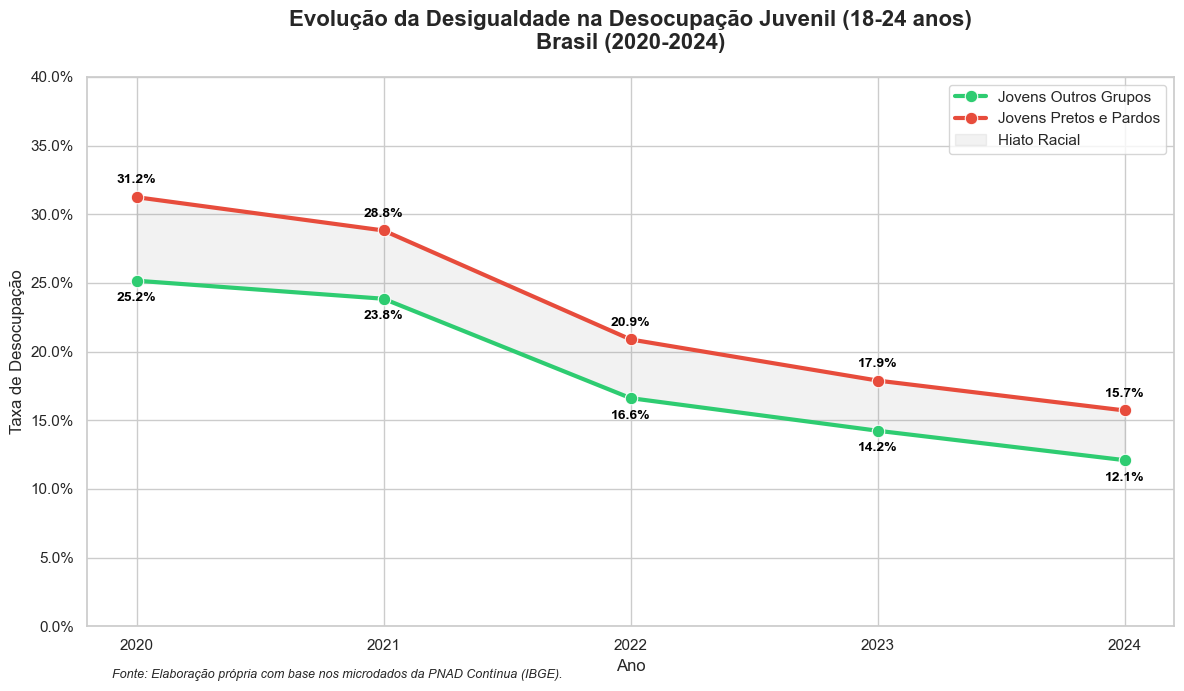

In [18]:
import matplotlib.ticker as mtick

# 1. Preparação para o Plot Avançado (Pivoteamento para calcular o Gap)
# Transformamos os dados para ter colunas separadas para cada grupo
df_pivot = df_resultados.pivot(index='Ano', columns='Grupo_Analise', values='Taxa_Desocupacao')
grupo_preto = df_pivot['Jovens Pretos e Pardos']
grupo_outros = df_pivot['Jovens Outros Grupos']

# Configuração do Tamanho e Estilo
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid") # Fundo limpo com linhas de grade

# 2. Plotagem das Linhas (Com cores específicas para contraste)
# Usamos 'zorder' para garantir que as linhas fiquem na frente do sombreado
sns.lineplot(data=df_resultados, x='Ano', y='Taxa_Desocupacao', hue='Grupo_Analise', 
             marker='o', linewidth=3, markersize=9, palette=['#2ecc71', '#e74c3c'], zorder=5)

# 3. Destaque do Hiato (Shading)
# Preenche a área entre as duas curvas para enfatizar a desigualdade
plt.fill_between(df_pivot.index, grupo_outros, grupo_preto, color='gray', alpha=0.1, label='Hiato Racial')

# 4. Anotação dos Valores (Data Labels)
# Loop para escrever o valor exato em cima de cada ponto
for line in range(0, df_resultados.shape[0]):
    ano_atual = df_resultados.Ano[line]
    taxa_atual = df_resultados.Taxa_Desocupacao[line]
    grupo = df_resultados.Grupo_Analise[line]
    
    # Ajuste fino da posição do texto (para não ficar em cima da linha)
    offset = 1 if grupo == 'Jovens Pretos e Pardos' else -1.5
    
    plt.text(
        ano_atual, 
        taxa_atual + offset, 
        f"{taxa_atual:.1f}%", 
        horizontalalignment='center', 
        size=10, 
        color='black', 
        weight='semibold'
    )

# 5. Formatação Profissional do Gráfico
plt.title('Evolução da Desigualdade na Desocupação Juvenil (18-24 anos)\nBrasil (2020-2024)', fontsize=16, weight='bold', pad=20)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Taxa de Desocupação', fontsize=12)

# Formata o eixo Y para mostrar "%"
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

# Ajustes de Legenda e Eixos
plt.legend(title='', fontsize=11, loc='upper right', frameon=True)
plt.xticks(df_resultados['Ano'].unique())
plt.ylim(0, 40) # Define um limite para dar respiro ao gráfico

# Rodapé com a Fonte (Padrão IPEA)
plt.figtext(0.1, 0.02, "Fonte: Elaboração própria com base nos microdados da PNAD Contínua (IBGE).", fontsize=9, style='italic')

plt.tight_layout()
plt.show()

## 6. Algoritmo de Processamento Final (Versão Condensada para Projeto)

Esta seção apresenta a versão otimizada e condensada do *script* de processamento, formatada especificamente para adequação ao limite de páginas do documento final do projeto. 

Apesar da síntese, este código preserva integralmente a lógica estrutural validada nas etapas anteriores:
1.  **Leitura Posicional Validada:** Utilização das posições manuais (`COLSPECS`) para superar a inconsistência do formato `.txt`.
2.  **Filtros de Escopo Estritos:** Seleção da população jovem (18-24 anos) pertencente à força de trabalho.
3.  **Cálculo Ponderado:** Aplicação do peso amostral (`V1028`) para garantir a representatividade populacional das estimativas.

Abaixo, apresenta-se o código e a tabela de resultados gerada por sua execução, comprovando a integridade do cálculo final apresentado no relatório.

    Ano          Grupo  Taxa
0  2020         Outros 25.16
1  2020  Pretos/Pardos 31.25
2  2021         Outros 23.85
3  2021  Pretos/Pardos 28.82
4  2022         Outros 16.61
5  2022  Pretos/Pardos 20.89
6  2023         Outros 14.24
7  2023  Pretos/Pardos 17.89
8  2024         Outros 12.10
9  2024  Pretos/Pardos 15.71


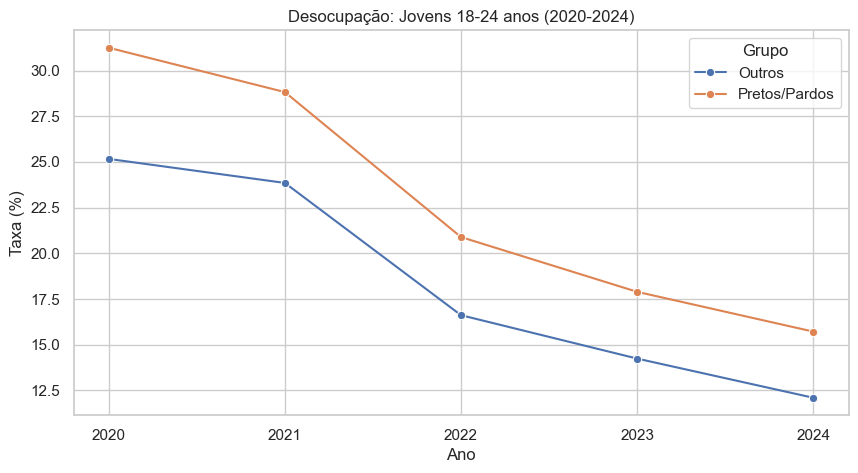

In [20]:
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt; import seaborn as sns
# 1. DEFINIÇÃO DE LAYOUT (Validado) E PROCESSAMENTO
COLSPECS = [(0,4), (4,5), (103,106), (106,107), (49,64), (409,410)] # Ano,Tri,Idade,Cor,Peso,Ocup
NAMES = ['Ano', 'Trimestre', 'Idade', 'Cor_Raca', 'Peso', 'Condicao_Ocupacao']

def processar(ano, tri):
    try:
        df = pd.read_fwf(f"PNADC_{tri:02d}{ano}.txt", colspecs=COLSPECS, header=None, names=NAMES, dtype=str)
        for c in ['Idade','Peso','Cor_Raca','Condicao_Ocupacao','Ano']: df[c] = pd.to_numeric(df[c], errors='coerce')
        df.dropna(subset=['Idade', 'Cor_Raca', 'Condicao_Ocupacao', 'Peso'], inplace=True)
        df = df[df['Idade'].between(18, 24) & df['Condicao_Ocupacao'].isin([1, 2])] # 18-24 e Força Trab.
        df['Desocupado'] = np.where(df['Condicao_Ocupacao'] == 2, 1, 0)
        df['Grupo'] = np.where(df['Cor_Raca'].isin([2, 4]), 'Pretos/Pardos', 'Outros')
        return df[['Ano', 'Grupo', 'Peso', 'Desocupado']]
    except: return None

# 3. CONSOLIDAÇÃO E CÁLCULO PONDERADO
dados = [processar(a, t) for a in range(2020, 2025) for t in range(1, 5)]
df_final = pd.concat([d for d in dados if d is not None])

calc_taxa = lambda x: (x.loc[x['Desocupado']==1, 'Peso'].sum() / x['Peso'].sum()) * 100
res = df_final.groupby(['Ano', 'Grupo']).apply(calc_taxa, include_groups=False).reset_index(name='Taxa')
print(res)

# 4. VISUALIZAÇÃO
plt.figure(figsize=(10, 5)); sns.lineplot(data=res, x='Ano', y='Taxa', hue='Grupo', marker='o')
plt.title('Desocupação: Jovens 18-24 anos (2020-2024)'); plt.ylabel('Taxa (%)'); plt.xticks(res.Ano.unique()); plt.show()